# On Countries, Criminals, and the Power of ❤️: An Analysis of Helicopter Escape Attempts and Success Chance

Helicopter escape is a rare event, yet when it happens, it normally involves high-profile criminals who have the resources and network to organise the risky attempt. These criminals are very dangerous if they're at large, thus it's important to reduce or prevent any further helicopter escapes. 

The first few steps in accomplishing that would be the identification of the following:

1. Which countries have the highest helicopter escape attempts?
2. Which countries have the highest helicopter escape success chance?

Also, we recently read the [story](https://apnews.com/article/d9df3592a19041822a3c4055f9536505) of Michel Vaujour's wife who took flying lessons for months and attempted to free her husband by piloting a helicopter on her own. Inspired by the story, we would like to additionally investigate if the power of love has an impact on success chance.

### Summary of Results

TODO: Write after everything else

## Tools and Methodologies

### Programming Language 

We'll be using [Julia](https://julialang.org/) — a relatively new general-purpose language but with strong emphasis numerical analysis and computational science. Frankly, we are quite new to Julia so the codes we'll write for the rest of this project do not reflect Julia's actual calibre as a data science programming language.

Aside from that, unlike Python, Julia's ecosystem are fairly small. Thus, the libraries we use are not necessarily the best, but they are what's currently available. Julia can interoperate with Python as well, though in this project, we choose to stick to Julia's packages.

### Type of Analysis

Our analysis will be simple in this project e.g bar charts, summary statistics, because our intention is to get an overview rather than a deep dive into the issue.

## Source of data

The data for this project is based on the [list of helicopter prison escapes](https://en.wikipedia.org/wiki/List_of_helicopter_prison_escapes) on Wikipedia. Wikipedia's content is crowd-sourced thus the quality of the article can vary depending on the contributors. Since we are not aware of any other sources that track helicopter escapes, we decided to use the stated Wikipedia's article while acknowledging the possible data quality issue.

The article is shared under the [Creative Commons Attribution-ShareAlike License 3.0](https://en.wikipedia.org/wiki/Wikipedia:Text_of_Creative_Commons_Attribution-ShareAlike_3.0_Unported_License) which permits the copying of content from the article. 

### Sections Relevancy

The first two sections, Getting the Data and Cleaning Up, are mostly technical and meant for setting up the data for easier and proper analysis. Feel free to skip them if you're only interested in the analyses and their results. 

# Getting the Data

## The How

The Wikipedia article doesn't provide a downloadable dataset for us to use. Because of this, we have to resort to web-scraping. Considering that all our data is on one page, we can web-scrape with a single function call thus we avoid overloading Wikipedia's server. Even if Wikipedia can withstand repeated visits, it's always good manners to consider if we're being respectful rather than assuming that we can do anything we want.

We also reviewed Wikipedia's [robots.txt](https://en.wikipedia.org/robots.txt) and found no line indicating that the article is disallowed for scraping. Another alternative we should consider when we use Wikipedia again in other projects is to use its [REST API](https://en.wikipedia.org/api/rest_v1/).



In [1]:
# import all the necessary packages for the whole project
using HTTP, Gumbo, DataFrames, Statistics, FreqTables, PlotlyJS, Colors, ColorSchemes

import AbstractTrees as AT, Plots as PLT, StatsBase as SB

#=
Notes on packages

HTTP          - handles GET requests
Gumbo         - an HTML parser based on Google's Gumbo parser
Statistics    - Julia's built-in statistics package containing only the essential statictical operations
FreqTables    - converts DataFrames, Vectors, etc into a frequency table
AbstractTrees - needed to iterate through the HTML elements
Plots         - Julia's built-in plotting package
StatsBase     - to provide some statistics operations not available in Statistics

=#

# by default, Jupyter won't display all columns in a dataframe
#
# we set the environment variable to override that behaviour, 
# thus displaying all columns (assuming column numbers <= 10000)
ENV["COLUMNS"]=10000

WebIO._IJuliaInit()

10000

In [2]:
# PLT.plotlyjs()

### Web-scrape the article and store the result locally for reusability

We start by sending a GET request to the article url. From there, we can store the response and then extract the response body.

Note that we've already scraped the article before writing this, but we've provided the relevant code for reference. 

In [3]:
# get the raw html from the wikipedia page: https://en.wikipedia.org/wiki/List_of_helicopter_prison_escapes
# do the following only if the data is not available locally
#=
response = HTTP.request("GET", "https://en.wikipedia.org/wiki/List_of_helicopter_prison_escapes")

response_body = String(response.body)
# print raw data to make sure the response is okay
println(response.status)
println(response.body)

# store locally
open("datasets/helicopter_escapes.html","w") do f
        write(f,response_body)
end
=#

# read the file from the raw html stored locally
# the html was extracted on 16/09/2022
raw_html = open(f->read(f, String),"../datasets/helicopter_escapes.html")

"<!DOCTYPE html>\n<html class=\"client-nojs\" lang=\"en\" dir=\"ltr\">\n<head>\n<meta charset=\"UTF-8\"/>\n<title>List of helicopter prison escapes - Wikipedia</title>\n<script>document.documentElement.className=\"client-js\";RLCONF={\"wgBreakFrames\":false,\"wgSeparatorTransformTable\":[\"\",\"\"],\"wgDigitTransformTable\":[\"\",\"\"],\"wgDefaultDateFormat\":\"dmy\",\"wgMonthNames\":[\"\",\"January\",\"February\",\"March\",\"April\",\"May\",\"June\",\"July\",\"August\",\"September\",\"October\",\"November\",\"December\"],\"wgRequestId\":\"6e0b92a5-42ff-47b4-94a5-92063aec8ef0\",\"wgCSPNonce\":false,\"wgCanonicalNamespace\":\"\",\"wgCanonicalSpecialPageName\":false,\"wgNamespaceNumber\":0,\"wgPageName\":\"List_of_helicopter_prison_escapes\",\"wgTitle\":\"List of helicopter prison escapes\",\"wgCurRevisionId\":1104271511,\"wgRevisionId\":1104271511,\"wgArticleId\":5531650,\"wgIsArticle\":true,\"wgIsRedirect\":false,\"wgAction\":\"view\",\"wgUserName\":null,\"wgUserGroups\":[\"*\"],\"wgCa

### Retrieve the element in body that contains the list of helicopter escapes

The response body will be formatted as an HTML, thus we'll have to convert the necessary sections into the appropriate Julia objects. To simplify traversal, we only take the body tag and ignore the rest. Traversal through the body element is by Pre-Order Depth First Search.

In [4]:
doc = parsehtml(raw_html)

html_el = doc.root

html_body_el = html_el[2]

table_el = HTMLElement(:div)

for elem in AT.PreOrderDFS(html_body_el) 
    try
        # access first element four times and at the end, check if it contains the "Date" text
        if text(elem[1][1][1][1]) == "Date"
            table_el = elem[1]
        end
    catch
        # ignore problematic tags
    end
end
table_el

HTMLElement{:tbody}:<tbody>
  <tr>
    <th style="width:11%;">
      Date
    </th>
    <th style="width:14%;">
      Prison name
    </th>
    <th style="width:5%;">
      Country
    </th>
    <th style="width:5%;">
      Succeeded
    </th>
    <th class="unsortable" style="width:15%;">
      Escapee(s)
    </th>
    <th class="unsortable" style="width:55%;">
      Details
    </th>
...


### Retrieve the column names

Next step will be the extraction of column names.

In [5]:
# table_el[1] contains the column names
# we extract our column names from the first child of the parent element
index = 0
column_names = String[]
for elem in AT.PreOrderDFS(table_el[1]) 
    if (index != 0) & (text(elem) ∉ column_names)   
         push!(column_names, text(elem))
    end
    index +=1
end

# remove the last column name which was not filtered by the for loop
pop!(column_names)
column_names

6-element Vector{String}:
 "Date"
 "Prison name"
 "Country"
 "Succeeded"
 "Escapee(s)"
 "Details"

### Merge both the extracted columns and list rows into a DataFrame

The last step is to merge both the extracted columns and rows into one dataframe.

In [6]:
# create an initial dictionary to store column name to values mapping
# we will use the dictionary to build the dataframe for the analysis
data_dict = Dict{String, Array{String}}()
for col in column_names
   data_dict[col] = String[] 
end

In [7]:
# table_el[2] and subsequent indexes contain the data
# we'll filter the headers out
rows = children(table_el)[2:49]

num_rows = size(rows)[1]

test = String[]

# traverses through all elements, extract all text, combine all of them into a single String, and return the String
function get_all_text(htmlelement; separator = "", removenewline=false)
    fulltext = ""
    for elem in AT.PreOrderDFS(htmlelement)
        if(typeof(elem) <: HTMLText)
            fulltext *= separator * text(elem)
        end
    end
    if removenewline 
        fulltext = chomp(fulltext)
    end
    fulltext
end

# loop through the rows too and push data into the appropriate dictionary keys
for idx in range(1, num_rows)
    # the following can be made into a for loop but the columns are few enough 
    # to justify manual typing
    date      = get_all_text(rows[idx][1])
    location  = get_all_text(rows[idx][2])
    country   = get_all_text(rows[idx][3])
    succeeded = get_all_text(rows[idx][4])
    escapees  = get_all_text(rows[idx][5], separator = ",", removenewline=true)
    details   = get_all_text(rows[idx][6])
    
    push!(data_dict["Date"], date)
    push!(data_dict["Prison name"], location)
    push!(data_dict["Country"], country)
    push!(data_dict["Succeeded"], succeeded)
    push!(data_dict["Escapee(s)"], escapees)
    push!(data_dict["Details"], details)
end
first(data_dict["Escapee(s)"],10)

10-element Vector{String}:
 ",Joel David Kaplan,Carlos Antonio Contreras Castro"
 ",JB O'Hagan,Seamus Twomey,Kevin Mallon"
 ",Garrett Brock Trapnell,Martin Joseph McNally,James Kenneth Johnson"
 ",Gérard Dupré,Daniel Beaumont"
 ",Marina Paquet (hijacker),Giles Arseneault (prisoner)"
 ",David McMillan"
 ",James Rodney Leonard,William Douglas Ballew,Jesse Glenn Smith"
 ",José Carlos dos Reis Encina, a.k.a. \"Escadinha\""
 ",Michel Vaujour"
 ",Samantha Lopez"

In [8]:
# create the dataframe
h_escapes = DataFrame(data_dict)

# print the first five rows to make sure everything works correctly
first(h_escapes[!, Not(:Details)], 5)

,Country,Date,Escapee(s),Prison name,Succeeded
,String,String,String,String,String
1,Mexico,"August 19, 1971",",Joel David Kaplan,Carlos Antonio Contreras Castro",Santa Martha Acatitla\n,Yes\n
2,Ireland,"October 31, 1973",",JB O'Hagan,Seamus Twomey,Kevin Mallon",Mountjoy Jail,Yes\n
3,United States,"May 24, 1978",",Garrett Brock Trapnell,Martin Joseph McNally,James Kenneth Johnson","United States Penitentiary, Marion",No\n
4,France,"February 27, 1981",",Gérard Dupré,Daniel Beaumont","Fleury-Mérogis, Essonne, Ile de France\n",Yes\n
5,Canada,"May 7, 1981",",Marina Paquet (hijacker),Giles Arseneault (prisoner)","Orsainville Prison, Quebec City\n",No\n


## Data Cleaning

### Country

Some country names have leading white spaces. Removing that would make the names cleaner and easier to use for analysis.

In [9]:
# strip the leading white space in the Country column
h_escapes[!, [:Country]] = select(h_escapes, :Country => ByRow(x -> string(strip(x))) => :Country)

first(h_escapes[!, [:Country]], 5)

,Country
,String
1,Mexico
2,Ireland
3,United States
4,France
5,Canada


### Date

Next, we'll simplify the date. We're only interested in the year the escape happened.

In [10]:
# change the date to only refer to the year
# also, change the type to Int64
h_escapes[!, [:Date]] = select(h_escapes, :Date => ByRow(x -> parse(Int, last(x, 4))) => :Date)

# rename Date to Year
h_escapes = rename(h_escapes, :Date => :Year)

,Country,Year,Details,Escapee(s),Prison name,Succeeded
,String,Int64,String,String,String,String
1,Mexico,1971,"Joel David Kaplan was a New York businessman who had been arrested for murder in 1962 in Mexico City and was incarcerated at the Santa Martha Acatitla prison in the Iztapalapa borough of Mexico City. Joel's sister, Judy Kaplan, arranged the means to help Kaplan escape, and on August 19, 1971, a helicopter landed in the prison yard. The guards mistakenly thought this was an official visit. In two minutes, Kaplan and his cellmate Carlos Antonio Contreras, a Venezuelan counterfeiter, were able to board the craft and were piloted away, before any shots were fired.[9] Both men were flown to Texas and then different planes flew Kaplan to California and Castro to Guatemala.[3] The Mexican government never initiated extradition proceedings against Kaplan.[9] The escape is told in a book, The 10-Second Jailbreak: The Helicopter Escape of Joel David Kaplan.[4] It also inspired the 1975 action movieBreakout, which starred Charles Bronson and Robert Duvall.[9]",",Joel David Kaplan,Carlos Antonio Contreras Castro",Santa Martha Acatitla\n,Yes\n
2,Ireland,1973,"On October 31, 1973 an IRA member hijacked a helicopter and forced the pilot to land in the exercise yard of Dublin's Mountjoy Jail's D Wing at 3:40 p.m., October 31, 1973. Three members of the IRA were able to escape: JB O'Hagan, Seamus Twomey and Kevin Mallon. Another prisoner who also was in the prison was quoted as saying, ""One shamefaced screw apologised to the governor and said he thought it was the new Minister for Defence (Paddy Donegan) arriving. I told him it was our Minister of Defence leaving.""\nThe Mountjoy helicopter escape became Republican lore and was immortalized by ""The Helicopter Song"", which contains the lines ""It's up like a bird and over the city. There's three men a'missing I heard the warder say"".[1]",",JB O'Hagan,Seamus Twomey,Kevin Mallon",Mountjoy Jail,Yes\n
3,United States,1978,"43-year-old Barbara Ann Oswald hijacked a Saint Louis-based charter helicopter and forced the pilot to land in the yard at USP Marion. While landing the aircraft, the pilot, Allen Barklage, who was a Vietnam War veteran, struggled with Oswald and managed to wrestle the gun away from her. Barklage then shot and killed Oswald, thwarting the escape.[10] A few months later Oswald's daughter hijacked TWA Flight 541 in an effort to free Trapnell.\n",",Garrett Brock Trapnell,Martin Joseph McNally,James Kenneth Johnson","United States Penitentiary, Marion",No\n
4,France,1981,"With the help of Serge Coutel, Gérard Dupré and Daniel Beaumont, succeed in the first and double helicopter escape of a French prison, in Fleury-Mérogis (Essonne), the best kept prison of France. The men hijacked a helicopter and its pilot that they rented to fly from Paris to Orléans. The pilot, Claude Fourcade, was taken hostage and was told that they were holding his wife and daughter hostage (which was not true) ... The flight turned into Paris - Fleury -Merogis - Porte d'Orléans.[11]",",Gérard Dupré,Daniel Beaumont","Fleury-Mérogis, Essonne, Ile de France\n",Yes\n
5,Canada,1981,"Marina Paquet held a sawed off shotgun against the back of the head of a helicopter pilot. She demanded that he land in the Orsainville prison courtyard, where her boyfriend (awaiting extradition to California on a murder charge) was set to escape. The pilot, Brian Jenner, feigned a panic attack, put the helicopter through some rough maneuvers and was then able to convince Paquet, in the back seat of the Jet Ranger, to turn over her shotgun and her knife. Jenner then gave her the choice of any landing spot, except the prison. She chose to go back to the airport.\nThe pilot then explained, in great detail, exactly where they were and where they would be landing on arrival at the Quebec City airport. He added that the police would surely be aware by then, that she had hijacked the helicopter but would not yet be aware that s

### Details

We don't need this at the moment and it clutters the display because of how text-heavy it is. So, removing it should simplify things.

In [11]:
# let's remove the details column so it doesn't clutter the display
# other than that, we don't need it at this moment
h_escapes = h_escapes[!, Not(:Details)]

# check if it's working properly
first(h_escapes, 5)

,Country,Year,Escapee(s),Prison name,Succeeded
,String,Int64,String,String,String
1,Mexico,1971,",Joel David Kaplan,Carlos Antonio Contreras Castro",Santa Martha Acatitla\n,Yes\n
2,Ireland,1973,",JB O'Hagan,Seamus Twomey,Kevin Mallon",Mountjoy Jail,Yes\n
3,United States,1978,",Garrett Brock Trapnell,Martin Joseph McNally,James Kenneth Johnson","United States Penitentiary, Marion",No\n
4,France,1981,",Gérard Dupré,Daniel Beaumont","Fleury-Mérogis, Essonne, Ile de France\n",Yes\n
5,Canada,1981,",Marina Paquet (hijacker),Giles Arseneault (prisoner)","Orsainville Prison, Quebec City\n",No\n


### Escapees

Due to the simplistic way we extracted the text from the HTML elements, we'll need to clean the escapees names to make them easier for processing.

We'll try to fill the missing escapees data first, and then make the escapee names more analyzable.

In [12]:
missing_escapees = select(h_escapes, "Escapee(s)" => ByRow(x -> x == ",—" ? missing : x) => :Escapees)
h_escapes.Escapees = missing_escapees[!, :Escapees]
# code for showing missing escapees columns
# h_escapes[ismissing.(h_escapes[!, "Escapee(s)"]), :]

48-element Vector{Union{Missing, String}}:
 ",Joel David Kaplan,Carlos Antonio Contreras Castro"
 ",JB O'Hagan,Seamus Twomey,Kevin Mallon"
 ",Garrett Brock Trapnell,Martin Joseph McNally,James Kenneth Johnson"
 ",Gérard Dupré,Daniel Beaumont"
 ",Marina Paquet (hijacker),Giles Arseneault (prisoner)"
 ",David McMillan"
 ",James Rodney Leonard,William Douglas Ballew,Jesse Glenn Smith"
 ",José Carlos dos Reis Encina, a.k.a. \"Escadinha\""
 ",Michel Vaujour"
 ",Samantha Lopez"
 ",André Bellaïche,Gianluigi Esposito,Luciano  Cipollari"
 ",Sydney Draper,John Kendall"
 ",Mahoney Danny ,Francis Mitchell,Randy Lackey"
 ⋮
 ",Nordin Benallal"
 ",Vasilis Paleokostas,Alket Rizai"
 ",Alexin Jismy,Fabrice Michel"
 ",Ashraf  Sekkaki, plus three other criminals"
 ",Brian Lawrence "
 ",Alexey Shestakov "
 ",Panagiotis Vlastos "
 ",Benjamin Hudon-Barbeau,Danny Provençal"
 ",Yves Denis,Denis Lefebvre,Serge Pomerleau"
 ",Pola Roupa,Nikos Maziotis"
 ",Rédoine Faïd"
 ",Kristel A. "

In [13]:
h_escapes[ismissing.(h_escapes[!, "Escapees"]), :]

,Country,Year,Escapee(s),Prison name,Succeeded,Escapees
,String,Int64,String,String,String,String?
1,France,1992,",—",Lyon Prison\n,Yes\n,missing
2,France,1992,",—","Touraine Central Prison, Tours",No\n,missing
3,Netherlands,1997,",—",De Geerhorst jail\n,No\n,missing
4,France,2000,",—",Lyon prison\n,Yes\n,missing
5,France,2001,",—",Fresnes prison\n,No\n,missing
6,Brazil,2002,",—",Parada Neto Penitentiary\n,Yes\n,missing
7,France,2005,",—",France\n,No\n,missing


If possible, we'll fill the missing escapee names with information from the Details column. If not, we should consider dropping them removing them from the all or some parts of the analysis.

In [14]:
# from reading the Details column, we've identified the following:
# index 18 - 3 escapees
# index 19 - 4 escapees
# index 22 - 1 escapees
# index 25 - 3 escapees
# index 28 - 2 escapees
# index 29 - 2 escapees
# index 32 - 3 escapees (data not available in the Detail column, but available here — source: https://web.archive.org/web/20110604154102/http://www.timesonline.co.uk/tol/news/world/article757427.ece)

missing_escapees_idx = []
for row in eachrow(h_escapes[!, :])
    if ismissing(row["Escapees"])
        push!(missing_escapees_idx, rownumber(row))
    end
end

# because the missing escapees were unnamed, we'll use the year of the escape and the prison name plus a number to identify each of them
# e.g. index 18 - 1992 Lyon 1, 1992 Lyon 2, 1992 Lyon 3

missing_escapees_imputations = [
                                 (18,3,"1992_Lyon"),
                                 (19,4,"1992_Touraine"),
                                 (22,3,"1997_De_Geerhorst"),
                                 (25,3,"2000_Lyon"),
                                 (28,2,"2001_Fresnes"),
                                 (29,2,"2002_Parada"),
                                 (32,3,"2005_France")
                                ]

for imputations in missing_escapees_imputations
    index = imputations[1]
    num_escapees = imputations[2]
    suffix = imputations[3]
    escapees = join(["$(suffix)_$num," for num in range(1,num_escapees)])
    h_escapes[index, :Escapees] = escapees
#     h_escapes[] 
    
end

h_escapes[missing_escapees_idx, [:Escapees]]

,Escapees
,String?
1,"1992_Lyon_1,1992_Lyon_2,1992_Lyon_3,"
2,"1992_Touraine_1,1992_Touraine_2,1992_Touraine_3,1992_Touraine_4,"
3,"1997_De_Geerhorst_1,1997_De_Geerhorst_2,1997_De_Geerhorst_3,"
4,"2000_Lyon_1,2000_Lyon_2,2000_Lyon_3,"
5,"2001_Fresnes_1,2001_Fresnes_2,"
6,"2002_Parada_1,2002_Parada_2,"
7,"2005_France_1,2005_France_2,2005_France_3,"


In [15]:
function extractnames(string)
    # match a sequence of anything except for commas and '-'
    # any match also optionally ends with either a newline or a word boundary
    matches = collect(eachmatch(r"(?<name>[^,—]+)[\n,\b]?", string))
    [match["name"] for match = matches]
end

new_escapees = transform(h_escapes, :Escapees => ByRow(x -> extractnames(x)) => :Escapees)[!, [6]]
new_escapees = select(new_escapees, :Escapees => ByRow(x -> isempty(x) ? missing : x) => :Escapees)
h_escapes.Escapees = new_escapees[!, "Escapees"]

first(h_escapes[!, [:Escapees]], 5)

,Escapees
,Array…
1,"[""Joel David Kaplan"", ""Carlos Antonio Contreras Castro""]"
2,"[""JB O'Hagan"", ""Seamus Twomey"", ""Kevin Mallon""]"
3,"[""Garrett Brock Trapnell"", ""Martin Joseph McNally"", ""James Kenneth Johnson""]"
4,"[""Gérard Dupré"", ""Daniel Beaumont""]"
5,"[""Marina Paquet (hijacker)"", ""Giles Arseneault (prisoner)""]"


One escapee name was not extracted properly — "José Carlos dos Reis Encina, a.k.a. "Escadinha". We received two names instead of one.

Aside from that, some escapees are grouped together. We decided to rename them as separate escapees identified by the group name and a number, instead of finding their actual names.

An example:

> Four members of the Manuel Rodriguez Patriotic Front --> MRPF 1, MRPF 2, MRPF 3, MRPF 4

In [16]:
# h_escapes = h_escapes[:, Not("Escapee(s)")]

# some values are a bit wrong and since there are not that many of them, we can just fix them manually
# index 8: """José Carlos dos Reis Encina, a.k.a. "Escadinha" """
# index 21: Four members of the Manuel Rodriguez Patriotic Front
# index 39: "Ashraf  Sekkaki", " plus three other criminals"

h_escapes[8, :Escapees] = ["José Carlos dos Reis Encina"]
h_escapes[21, :Escapees] = ["MRPF 1", "MRPF 2", "MRPF 3", "MRPF 4"]
h_escapes[40, :Escapees] = ["Ashraf  Sekkaki", "Criminal 1", "Criminal 2", "Criminal 3"]

first(h_escapes, 20)

,Country,Year,Escapee(s),Prison name,Succeeded,Escapees
,String,Int64,String,String,String,Array…
1,Mexico,1971,",Joel David Kaplan,Carlos Antonio Contreras Castro",Santa Martha Acatitla\n,Yes\n,"[""Joel David Kaplan"", ""Carlos Antonio Contreras Castro""]"
2,Ireland,1973,",JB O'Hagan,Seamus Twomey,Kevin Mallon",Mountjoy Jail,Yes\n,"[""JB O'Hagan"", ""Seamus Twomey"", ""Kevin Mallon""]"
3,United States,1978,",Garrett Brock Trapnell,Martin Joseph McNally,James Kenneth Johnson","United States Penitentiary, Marion",No\n,"[""Garrett Brock Trapnell"", ""Martin Joseph McNally"", ""James Kenneth Johnson""]"
4,France,1981,",Gérard Dupré,Daniel Beaumont","Fleury-Mérogis, Essonne, Ile de France\n",Yes\n,"[""Gérard Dupré"", ""Daniel Beaumont""]"
5,Canada,1981,",Marina Paquet (hijacker),Giles Arseneault (prisoner)","Orsainville Prison, Quebec City\n",No\n,"[""Marina Paquet (hijacker)"", ""Giles Arseneault (prisoner)""]"
6,Australia,1983,",David McMillan",Pentridge (HM Prison),No\n,"[""David McMillan""]"
7,United States,1985,",James Rodney Leonard,William Douglas Ballew,Jesse Glenn Smith","Perry Correctional Institution, Pelzer, South Carolina",Yes\n,"[""James Rodney Leonard"", ""William Douglas Ballew"", ""Jesse Glenn Smith""]"
8,Brazil,1985,",José Carlos dos Reis Encina, a.k.a. ""Escadinha""","Cândido Mendes penitentiary, Ilha Grande, Rio de Janeiro",Yes\n,"[""José Carlos dos Reis Encina""]"
9,France,1986,",Michel Vaujour",Prison de la Santé,Yes\n,"[""Michel Vaujour""]"


In [17]:
# finish dropping the redundant column Escapee(s)
h_escapes = h_escapes[!, Not("Escapee(s)")]
first(h_escapes, 5)

,Country,Year,Prison name,Succeeded,Escapees
,String,Int64,String,String,Array…
1,Mexico,1971,Santa Martha Acatitla\n,Yes\n,"[""Joel David Kaplan"", ""Carlos Antonio Contreras Castro""]"
2,Ireland,1973,Mountjoy Jail,Yes\n,"[""JB O'Hagan"", ""Seamus Twomey"", ""Kevin Mallon""]"
3,United States,1978,"United States Penitentiary, Marion",No\n,"[""Garrett Brock Trapnell"", ""Martin Joseph McNally"", ""James Kenneth Johnson""]"
4,France,1981,"Fleury-Mérogis, Essonne, Ile de France\n",Yes\n,"[""Gérard Dupré"", ""Daniel Beaumont""]"
5,Canada,1981,"Orsainville Prison, Quebec City\n",No\n,"[""Marina Paquet (hijacker)"", ""Giles Arseneault (prisoner)""]"


## Prison name

Some prison name has an extra newline at the end. We should remove that.

In [18]:
# strip newlines
h_escapes[!, ["Prison name"]] = select(h_escapes, "Prison name" => ByRow(x -> chomp(x)) => "Prison name")

,Prison name
,SubStrin…
1,Santa Martha Acatitla
2,Mountjoy Jail
3,"United States Penitentiary, Marion"
4,"Fleury-Mérogis, Essonne, Ile de France"
5,"Orsainville Prison, Quebec City"
6,Pentridge (HM Prison)
7,"Perry Correctional Institution, Pelzer, South Carolina"
8,"Cândido Mendes penitentiary, Ilha Grande, Rio de Janeiro"
9,Prison de la Santé


### Succeeded

The "Yes" and "No" are a little bit tedious to analyse compared to booleans. Converting them is our next step.

In [19]:
# convert the Succeeded column from a String into a Bool column
h_escapes[!, [:Succeeded]] = select(h_escapes, :Succeeded => ByRow(x -> x == "Yes\n" ? true : false) => :Succeeded)

first(h_escapes[!, [:Succeeded]], 10)

,Succeeded
,Bool
1,1
2,1
3,0
4,1
5,0
6,0
7,1
8,1
9,1


### Result of data cleaning



The final data will be a dataframe listing helicopter escape attempts worldwide. The columns and their descriptions are as follows:

| Column Name |                           Description                          |Data Type       | 
|-------------|:--------------------------------------------------------------:|:--------------:|
| Country     | The name of the country the escape attempt happened            |String          | 
| Year        | The year the escape attempt happened                           |Integer         | 
| Prison name | The name of the prison the escapees were trying to escape from |String          | 
| Succeeded   | Whether the escapees successfully escaped from the prison      |Boolean         | 
| Escapees    | The name of all escapees involved in the escape attempt        |Array of String | 


## Analysis

### Attempts Per Year

This is not the main goal of our project, but it helps to provide an overview on how attempt numbers change throughout the recorded years.

In [21]:
# find min and max values of the Year column
min_year = minimum(h_escapes[!, :Year])
max_year = maximum(h_escapes[!, :Year])

# create a list of tuples with year as the first value and 0 as the second
attempts_per_year = Tuple{Int64, Int64}[]
for y in range(min_year, max_year)
    push!(attempts_per_year, (y,0))
end

first(attempts_per_year, 10)

10-element Vector{Tuple{Int64, Int64}}:
 (1971, 0)
 (1972, 0)
 (1973, 0)
 (1974, 0)
 (1975, 0)
 (1976, 0)
 (1977, 0)
 (1978, 0)
 (1979, 0)
 (1980, 0)

In [22]:
# we'll map the year with the corresponding number of attempts
for row in eachrow(h_escapes)
    attempts_size = size(attempts_per_year)[1]
    for idx in range(1, attempts_size)
        num_attempts = attempts_per_year[idx][2]
        year = attempts_per_year[idx][1]
        # the second element in row is the year value
        if row[2] == year
            incr_attempts = num_attempts + 1
            attempts_per_year[idx] = (year, incr_attempts) 
        end
    end
end

first(attempts_per_year, 10)

10-element Vector{Tuple{Int64, Int64}}:
 (1971, 1)
 (1972, 0)
 (1973, 1)
 (1974, 0)
 (1975, 0)
 (1976, 0)
 (1977, 0)
 (1978, 1)
 (1979, 0)
 (1980, 0)

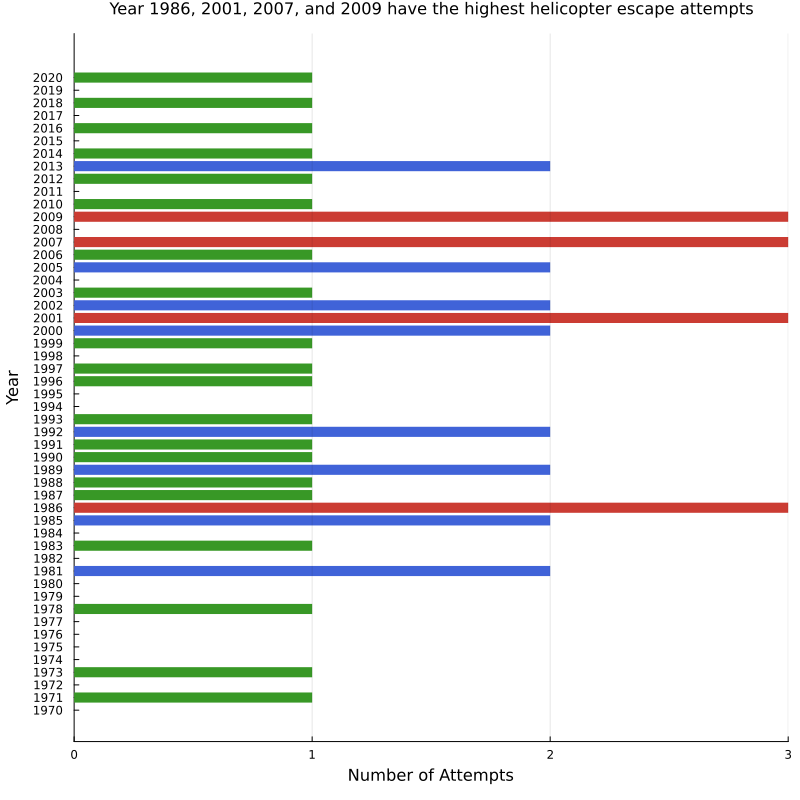

In [23]:

logocolors = Colors.JULIA_LOGO_COLORS

color_attempts_py = []

for tuple in attempts_per_year
   attempts = tuple[2]
    if attempts == 3
        push!(color_attempts_py, logocolors.red)
    elseif attempts == 2
        push!(color_attempts_py, logocolors.blue)
    else
        push!(color_attempts_py, logocolors.green)
    end
    
end
cs1 = ColorScheme(range(colorant"red", colorant"green", length=5))
# plot a horizontal barplot for attempts_per_year

PLT.bar(attempts_per_year, 
        label         = nothing, 
        yticks        = 1970:2020, 
        xticks        = 0:3,
        orientation   = :horizontal, 
        size          = (800,800), 
        xlabel        = "Number of Attempts",
        ylabel        = "Year",
        fillcolors    = color_attempts_py,
        linecolor     = :transparent,
        grid          = false,
        xlim          = (0,3),
        title         = "Year 1986, 2001, 2007, and 2009 have the highest helicopter escape attempts",      
        titlefontsize = 11,
)

PLT.plot!([1,2,3], seriestype="vline", c=:black, alpha=0.1, label = nothing, )


### Number of Attempts Per Country

To have a greater impact in preventing helicopter escapes, we decided to focus on identifying the three countries with the most helicopter escape attempts. A high number of attempts doesn't necessarily tell us that the country's prison is insecure, because it's possible for a prison to be very secure but the criminals it holds are more daring than those in other countries. But, it could also be a hint that the criminals were able to see a flaw in the security, thus they wanted to take advantage of that.

In [24]:
# create a frequency table for attempts per country
attempts_country_table = freqtable(h_escapes[!, [:Country]], :Country)

# sort by attempts number and descending
sort(attempts_country_table, rev=true)

15-element Named Vector{Int64}
Country        │ 
───────────────┼───
France         │ 15
United States  │  8
Belgium        │  4
Canada         │  4
Greece         │  4
Australia      │  2
Brazil         │  2
United Kingdom │  2
Chile          │  1
Ireland        │  1
Italy          │  1
Mexico         │  1
Netherlands    │  1
Puerto Rico    │  1
Russia         │  1

France has the highest helicopter escape attempts at 15. The United State has the second highest number at 7 which is half of France. Belgium, Canada, and Greece are tie for the third highest number at 4 each which is half of the United States and quarter of France.

Knowing that France and USA have many attempts, we can investigate if the attempts happened at the same prison. If some prisons have more attempts than others, we can specifically focus on them instead.

In [25]:
france_escapes = filter( x -> x[:Country] == "France", h_escapes)

# create a frequency table for attempts per country
france_prison_table = freqtable(france_escapes[!, ["Prison name"]], "Prison name")

13-element Named Vector{Int64}
Prison name                              │ 
─────────────────────────────────────────┼──
"Aiton Prison"                           │ 1
"Domenjod Prison, Réunion"               │ 1
"Draguignan prison"                      │ 1
"Fleury-Mérogis, Essonne, Ile de France" │ 1
"France"                                 │ 1
"Fresnes prison"                         │ 1
"Grasse prison"                          │ 1
"Luynes prison"                          │ 2
"Lyon Prison"                            │ 1
"Lyon prison"                            │ 1
"Prison de la Santé"                     │ 1
"Réau, near Paris"                       │ 1
"Touraine Central Prison, Tours"         │ 2

Lyon Prison, Luynes Prison, and Touraine Central Prison have 2 attempts each. We should note those prisons because they could be less secure in preventing helicopter escape attempts than the rest.

In [26]:
usa_escapes = filter( x -> x[:Country] == "United States", h_escapes)

# create a frequency table for attempts per country
usa_prison_table = freqtable(usa_escapes[!, ["Prison name"]], "Prison name")

8-element Named Vector{Int64}
Prison name                                                                     │ 
────────────────────────────────────────────────────────────────────────────────┼──
"Arkansas Valley Correctional Facility"                                         │ 1
"Federal Correctional Institution, Dublin"                                      │ 1
"Federal Holding Facility, Miami, FL"                                           │ 1
"Las Cucharas prison, Puerto Rico"                                              │ 1
"Martin Treatment Center for Sexually Violent Predators, Martin County Florida" │ 1
"Perry Correctional Institution, Pelzer, South Carolina"                        │ 1
"Santa Fe prison"                                                               │ 1
"United States Penitentiary, Marion"                                            │ 1

The USA has an even spread with all prisons only having 1 attempt each.

In [ ]:
###

In [27]:
# create a dictionary 
attempts_country_dict = SB.countmap(h_escapes[!, :Country])

# create a new dataframe based on the attempts per country frequency table
# this is required for country-based analysis
attempts_country_df = DataFrame("Country" => [k for k=keys(attempts_country_dict)],
          "Attempts" => [v for v=values(attempts_country_dict)])


,Country,Attempts
,String,Int64
1,Greece,4
2,Belgium,4
3,Canada,4
4,Chile,1
5,France,15
6,Russia,1
7,United States,8
8,United Kingdom,2
9,Mexico,1


In [28]:
attempts_country_df = combine(groupby(h_escapes, :Country), 
    :Year => (y -> size(y, 1)) => :Attempts, 
    :Succeeded => count => :SuccessfulAttempts)

attempts_country_df[!, :SuccessChance] = attempts_country_df.SuccessfulAttempts ./ attempts_country_df.Attempts .* 100

sort(attempts_country_df, :SuccessChance, rev=true)

,Country,Attempts,SuccessfulAttempts,SuccessChance
,String,Int64,Int64,Float64
1,Mexico,1,1,100.0
2,Ireland,1,1,100.0
3,Brazil,2,2,100.0
4,Italy,1,1,100.0
5,Puerto Rico,1,1,100.0
6,Chile,1,1,100.0
7,Russia,1,1,100.0
8,United States,8,6,75.0
9,Canada,4,3,75.0


In [29]:
# some of the countries only have a single attempt; 
# a single attempt is not enough for us to be confident that the success chance is representative of the prison's security
# i.e. will the success chance hold in future attempts
#
# let's only consider a country with at least 3 attempts for analysis
filter(row -> row.Attempts > 2, attempts_country_df)

,Country,Attempts,SuccessfulAttempts,SuccessChance
,String,Int64,Int64,Float64
1,United States,8,6,75.0
2,France,15,11,73.3333
3,Canada,4,3,75.0
4,Greece,4,2,50.0
5,Belgium,4,2,50.0


In [30]:
# we can use the size of the Escapees array to get the number of escapees per attempt
num_escapees = select(h_escapes, :Escapees => ByRow(array -> typeof(array) == Missing ? array : size(array,1)) => :NumEscapees)
h_escapes.NumEscapees = num_escapees[!, :NumEscapees]
first(h_escapes, 50)

,Country,Year,Prison name,Succeeded,Escapees,NumEscapees
,String,Int64,SubStrin…,Bool,Array…,Int64
1,Mexico,1971,Santa Martha Acatitla,1,"[""Joel David Kaplan"", ""Carlos Antonio Contreras Castro""]",2
2,Ireland,1973,Mountjoy Jail,1,"[""JB O'Hagan"", ""Seamus Twomey"", ""Kevin Mallon""]",3
3,United States,1978,"United States Penitentiary, Marion",0,"[""Garrett Brock Trapnell"", ""Martin Joseph McNally"", ""James Kenneth Johnson""]",3
4,France,1981,"Fleury-Mérogis, Essonne, Ile de France",1,"[""Gérard Dupré"", ""Daniel Beaumont""]",2
5,Canada,1981,"Orsainville Prison, Quebec City",0,"[""Marina Paquet (hijacker)"", ""Giles Arseneault (prisoner)""]",2
6,Australia,1983,Pentridge (HM Prison),0,"[""David McMillan""]",1
7,United States,1985,"Perry Correctional Institution, Pelzer, South Carolina",1,"[""James Rodney Leonard"", ""William Douglas Ballew"", ""Jesse Glenn Smith""]",3
8,Brazil,1985,"Cândido Mendes penitentiary, Ilha Grande, Rio de Janeiro",1,"[""José Carlos dos Reis Encina""]",1
9,France,1986,Prison de la Santé,1,"[""Michel Vaujour""]",1


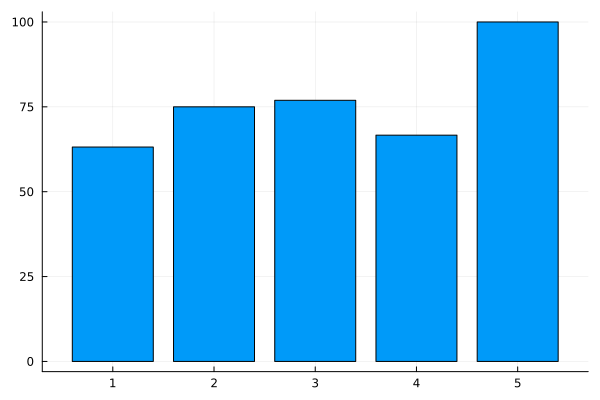

In [31]:
num_escapees_df = combine(
                            groupby(h_escapes, :NumEscapees), 
                            :NumEscapees => (num -> size(num, 1)) => :Attempts, 
                            :Succeeded => count => :SuccessfulAttempts
                         )

num_escapees_df[!, :SuccessChance] = num_escapees_df.SuccessfulAttempts ./ num_escapees_df.Attempts .* 100

PLT.bar(num_escapees_df[:, :NumEscapees], num_escapees_df[:, :SuccessChance],  label = nothing)

In [32]:
# to see the exact success chance
sort(num_escapees_df, :SuccessChance, rev=true)

,NumEscapees,Attempts,SuccessfulAttempts,SuccessChance
,Int64,Int64,Int64,Float64
1,5,1,1,100.0
2,3,13,10,76.9231
3,2,12,9,75.0
4,4,3,2,66.6667
5,1,19,12,63.1579


In [33]:
escapees_arr = String[]
for escapees in skipmissing(h_escapes[:, :Escapees])
    # we'll have to remove the leading whitespace in the inner loop before pushing the value in
    for escapee in escapees
       push!(escapees_arr, strip(escapee)) 
    end
end
sort(freqtable(escapees_arr), rev=true)

97-element Named Vector{Int64}
Dim1                            │ 
────────────────────────────────┼──
Michel Vaujour                  │ 2
Pascal Payet                    │ 2
1992_Lyon_1                     │ 1
1992_Lyon_2                     │ 1
1992_Lyon_3                     │ 1
1992_Touraine_1                 │ 1
1992_Touraine_2                 │ 1
1992_Touraine_3                 │ 1
1992_Touraine_4                 │ 1
1997_De_Geerhorst_1             │ 1
1997_De_Geerhorst_2             │ 1
⋮                                 ⋮
Samantha Lopez                  │ 1
Seamus Twomey                   │ 1
Serge Pomerleau                 │ 1
Steven Whitsett                 │ 1
Sydney Draper                   │ 1
Vasilis Paleokostas             │ 1
Vassilis Paleokostas            │ 1
Victor Diaz                     │ 1
William Douglas Ballew          │ 1
William Lane                    │ 1
Yves Denis                      │ 1

In [34]:
#= power of love analysis
 each row's PowerOfLove value is 1 if it involves any help from a lover (e.g. partner, lover, wife, husband, etc); relationship by blood is not included in the definition

 the values are assigned manually; considering the limited amount of data, it is still a feasible operation
 
 9 michel vaujour - wife piloted helicopter
 46 greece roupa  - mistress organised escape
 24 usa whitsett 
 5 canada marina paquet
 10 samantha lopez usa
 23 australia john killick
 48 kristel a - 
=#

powerof❤️ = [false for n=1:48]

for saved in [9, 46, 24, 5, 10, 23, 48]
   powerof❤️[saved] = true 
end
h_escapes.PowerOf❤️ = powerof❤️
filter(r -> r.PowerOf❤️ == true, h_escapes)

,Country,Year,Prison name,Succeeded,Escapees,NumEscapees,PowerOf❤️
,String,Int64,SubStrin…,Bool,Array…,Int64,Bool
1,Canada,1981,"Orsainville Prison, Quebec City",0,"[""Marina Paquet (hijacker)"", ""Giles Arseneault (prisoner)""]",2,1
2,France,1986,Prison de la Santé,1,"[""Michel Vaujour""]",1,1
3,United States,1986,"Federal Correctional Institution, Dublin",1,"[""Samantha Lopez""]",1,1
4,Australia,1999,Metropolitan Remand and Reception Centre,1,"[""John Killick""]",1,1
5,United States,2000,"Martin Treatment Center for Sexually Violent Predators, Martin County Florida",1,"[""Steven Whitsett""]",1,1
6,Greece,2016,Thiva,0,"[""Pola Roupa"", ""Nikos Maziotis""]",2,1
7,Belgium,2020,"Forest prison, Brussels",0,"[""Kristel A. ""]",1,1


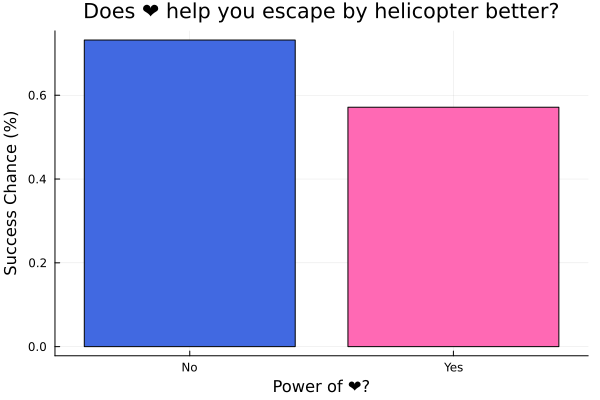

In [35]:
# repeat similar code for showing success change
# considering how many times the following code is repeated, we should turn it into a function later
powerof❤️_df = combine(
                            groupby(h_escapes, :PowerOf❤️), 
                                               :PowerOf❤️ => (num -> size(num, 1)) => :Attempts, 
                                               :Succeeded => count => :SuccessfulAttempts)

powerof❤️_df[!, :SuccessChance] = powerof❤️_df.SuccessfulAttempts ./ powerof❤️_df.Attempts

PLT.bar(powerof❤️_df[:, :PowerOf❤️], powerof❤️_df[:, :SuccessChance], xticks= ([0.0:1.0;], ["No", "Yes"]), xlabel="Power of ❤️?", ylabel="Success Chance (%)", title="Does ❤️ help you escape by helicopter better?",  label = nothing, fillcolor=["royalblue", "hotpink"])

In [36]:
poweroflove_df

LoadError: UndefVarError: poweroflove_df not defined

### Iterations

180922 - Dataquest suggestions
150922 - Initial dataquest requirements

In [37]:
# # Archive

# # next, let's prepare the original dataframe for analysing number of escapees and how that affects success chance
# # we'll start by examining the escapees column
# first(h_escapes[!, "Escapee(s)"], 20)

# function extractnames(string)
#     matches = collect(eachmatch(r"(?<name>[^,—]+)[\n,\b]?", string))
#     [match["name"] for match = matches]
# end

# extractnames(",José Carlos dos Reis Encina, a.k.a. \"Escadinha\"")


# # for text in h_escapes[!, "Escapee(s)"]
# #    println(text) 
# # end
# # h_escapes[!, ["Escapee(s)"]] = 
# new_escapees = transform(h_escapes, "Escapee(s)" => ByRow(x -> extractnames(x)) => "Escapees")[!, [6]]
# new_escapees = select(new_escapees, :Escapees => ByRow(x -> isempty(x) ? missing : x) => :Escapees)
# h_escapes.Escapees = new_escapees[!, "Escapees"]




In [38]:
# h_escapes = h_escapes[:, Not("Escapee(s)")]

# some values are a bit wrong and since there are not that many of them, we can just fix them manually
# index 8: """José Carlos dos Reis Encina, a.k.a. "Escadinha" """
# index 21: Four members of the Manuel Rodriguez Patriotic Front
# index 39: "Ashraf  Sekkaki", " plus three other criminals"

# h_escapes[8, :Escapees] = ["José Carlos dos Reis Encina"]
# h_escapes[21, :Escapees] = ["MRPF 1", "MRPF 2", "MRPF 3", "MRPF 4"]
# h_escapes[39, :Escapees] = ["Ashraf  Sekkaki", "Criminal 1", "Criminal 2", "Criminal 3"]

In [39]:
# # the original data need to be modified further for additional analyses
# # first, we'll convert the Succeeded column from a String into a Bool column
# h_escapes[!, [:Succeeded]] = select(h_escapes, :Succeeded => ByRow(x -> x == "Yes\n" ? true : false) => :Succeeded)